# Import libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray

from tensorflow.keras.models import Model, load_model, save_model



from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import opendatasets as od

from utils import *
from Unet_Model import UNET


# Setting parametrizes

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_TARGET_SIZE = (IMG_HEIGHT,IMG_WIDTH)
EPOCHS = 20
BATCH_SIZE = 32
LR = 1e-4

# Downloading the dataset from Kaggle

To download the dataset,you need username and key for downloading the dataset from 'opendataset' library.

You can also download the dataset from https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation directly.

In [3]:
od.download("https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation")

Skipping, found downloaded files in ".\lgg-mri-segmentation" (use force=True to force download)


# Loading the image and mask paths

In [4]:
TRAIN_IMG_FILENAMES = []

# Get mask images
MASK_IMG_FILENAMES = glob('./lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# Get train images
for i in MASK_IMG_FILENAMES:
    TRAIN_IMG_FILENAMES.append(i.replace('_mask', ''))

print(TRAIN_IMG_FILENAMES[:5])
print(f"Number of train images : {len(TRAIN_IMG_FILENAMES)}")

['./lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', './lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', './lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', './lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', './lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif']
Number of train images : 3929


# Plotting few images and masks

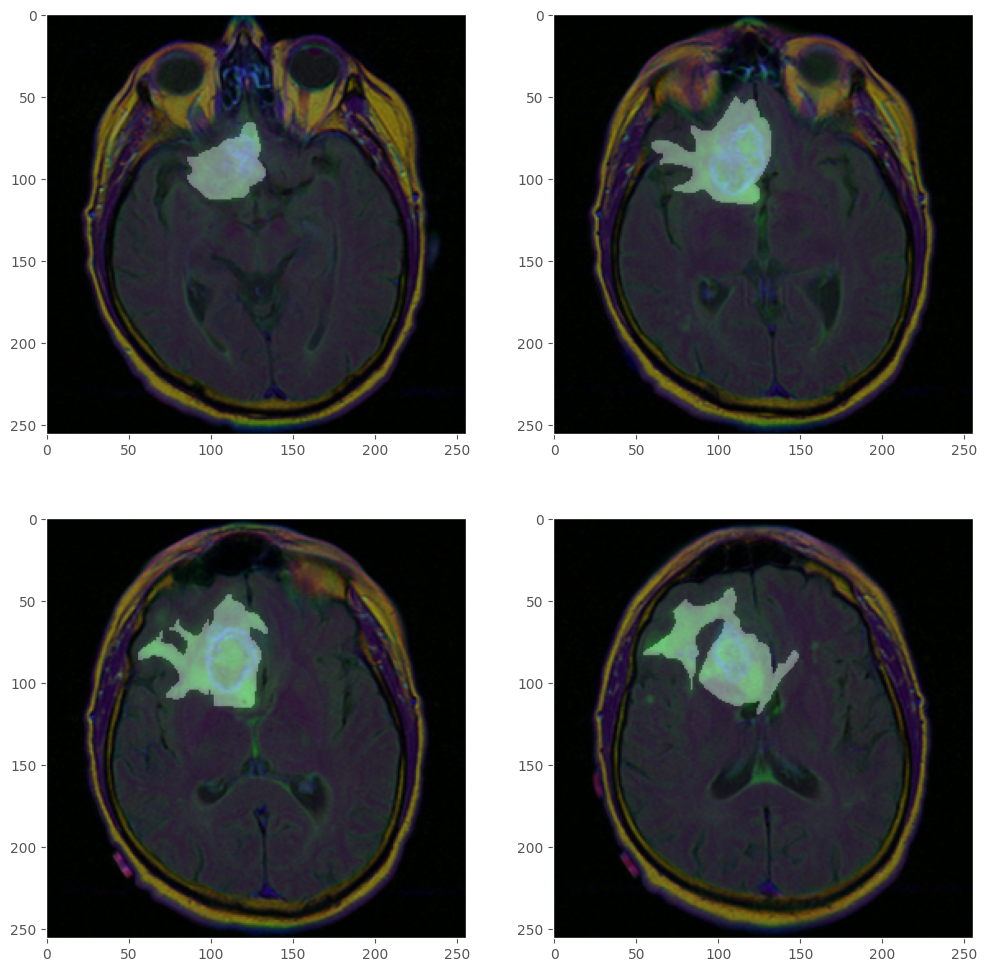

In [5]:
plot_samples(2,2,TRAIN_IMG_FILENAMES, MASK_IMG_FILENAMES )

# Create data frame and split data on train set, validation set and test set

In [6]:
df = pd.DataFrame(data={'images': TRAIN_IMG_FILENAMES, 'mask': MASK_IMG_FILENAMES })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [7]:
df_train

,images,mask
1053,./lgg-mri-segmentation/lgg-mri-segmentation/ka...,./lgg-mri-segmentation/lgg-mri-segmentation/ka...
1060,./lgg-mri-segmentation/lgg-mri-segmentation/ka...,./lgg-mri-segmentation/lgg-mri-segmentation/ka...
1943,./lgg-mri-segmentation/lgg-mri-segmentation/ka...,./lgg-mri-segmentation/lgg-mri-segmentation/ka...
2845,./lgg-mri-segmentation/lgg-mri-segmentation/ka...,./lgg-mri-segmentation/lgg-mri-segmentation/ka...
1407,./lgg-mri-segmentation/lgg-mri-segmentation/ka...,./lgg-mri-segmentation/lgg-mri-segmentation/ka...
...,...,...
209,./lgg-mri-segmentation/lgg-mri-segmentation/ka...,./lgg-mri-segmentation/lgg-mri-segmentation/ka...
3684,./lgg-mri-segmentation/lgg-mri-segmentation/ka...,./lgg-mri-segmentation/lgg-mri-segmentation/ka...
887,./lgg-mri-segmentation/lgg-mri-segmentation/ka...,./lgg-mri-segmentation/lgg-mri-segmentation/ka...
1654,./lgg-mri-segmentation/lgg-mri-segmentation/ka...,./lgg-mri-segmentation/lgg-mri-segmentation/ka...


# Data genertator, data augmentation and adjust data

In [8]:
def data_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=IMG_TARGET_SIZE,
    seed=1,
):

    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="images",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [9]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [10]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = data_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=IMG_TARGET_SIZE)
    
val_gen = data_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMG_TARGET_SIZE)

# Analyzing batch images and labels

In [11]:
sample_batch_images,sample_batch_labels = next(train_gen)

Found 2828 validated image filenames.
Found 2828 validated image filenames.


In [12]:
print(sample_batch_images.shape)
print(sample_batch_labels.shape)

(32, 256, 256, 3)
(32, 256, 256, 1)


In [13]:
sample_batch_images[15].shape

(256, 256, 3)

Text(0.5, 0, 'Tumor')

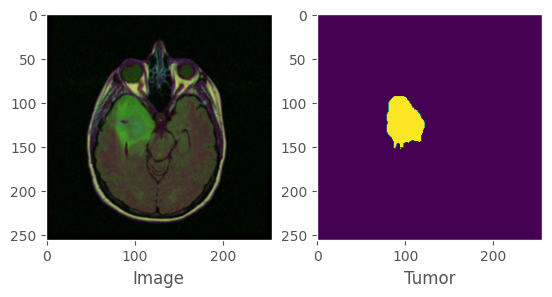

In [84]:
plt.subplot(1,2,1)
plt.imshow(sample_batch_images[28])
plt.grid(False)
plt.xlabel("Image")

plt.subplot(1,2,2)
plt.imshow(sample_batch_labels[28])
plt.grid(False)
plt.xlabel("Tumor")


# Defining the model

In [15]:
model = UNET(n_classes = 1,IMG_WIDTH = IMG_WIDTH,
                   IMG_HEIGHT = IMG_HEIGHT,
                  IMG_CHANNELS = 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 4)  112         ['lambda[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 4)  0           ['conv2d[0][0]']             

 spose)                                                                                           
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 8)  0           ['conv2d_transpose_3[0][0]',     
                                                                  'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 4)  292         ['concatenate_3[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 256, 256, 4)  0           ['conv2d_16[0][0]']              
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 4)  148         ['dropout_8[0][0]']              
          

# Setting callbacks

In [16]:
callbacks = []
# Save best weights with ModelCheckpoint
checkpoint = ModelCheckpoint('unet_model.hdf5', verbose=1, save_best_only=True)

# Reduce learning rate with conditions
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.1,
                             patience=5,
                             verbose=2,
                             min_lr=1e-8)

callbacks.append(checkpoint)
callbacks.append(reduce_lr)

print(callbacks)

[<keras.callbacks.ModelCheckpoint object at 0x000001EE1833E6D0>, <keras.callbacks.ReduceLROnPlateau object at 0x000001EE206AC880>]


# Setting optimizer and loss function

In [17]:
# Choose Adam optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# Choose loss function
loss_fn = dice_coefficients_loss

# Compile all metrics
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["binary_accuracy", iou, dice_coefficients])


# Fitting the model

In [18]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE,
                    epochs=EPOCHS, 
                    callbacks=callbacks)

Epoch 1/20
89/88 [==============================] - ETA: -1s - loss: -0.0225 - binary_accuracy: 0.3665 - iou: 0.0114 - dice_coefficients: 0.0226Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02427, saving model to unet_model.hdf5
88/88 [==============================] - 217s 2s/step - loss: -0.0225 - binary_accuracy: 0.3665 - iou: 0.0114 - dice_coefficients: 0.0226 - val_loss: -0.0243 - val_binary_accuracy: 0.4746 - val_iou: 0.0120 - val_dice_coefficients: 0.0237 - lr: 1.0000e-04
Epoch 2/20
89/88 [==============================] - ETA: -1s - loss: -0.0306 - binary_accuracy: 0.6433 - iou: 0.0155 - dice_coefficients: 0.0304
Epoch 2: val_loss improved from -0.02427 to -0.03073, saving model to unet_model.hdf5
88/88 [==============================] - 257s 3s/step - loss: -0.0306 - binary_accuracy: 0.6433 - iou: 0.0155 - dice_coefficients: 0.0304 - val_loss: -0.0307 - val_binary_accuracy: 0.8980 - val_iou: 0.0153 - val_di

89/88 [==============================] - ETA: -1s - loss: -0.5945 - binary_accuracy: 0.9923 - iou: 0.4275 - dice_coefficients: 0.5948
Epoch 18: val_loss did not improve from -0.45542
88/88 [==============================] - 273s 3s/step - loss: -0.5945 - binary_accuracy: 0.9923 - iou: 0.4275 - dice_coefficients: 0.5948 - val_loss: -0.3961 - val_binary_accuracy: 0.9774 - val_iou: 0.2707 - val_dice_coefficients: 0.4102 - lr: 1.0000e-06
Epoch 19/20
89/88 [==============================] - ETA: -1s - loss: -0.5995 - binary_accuracy: 0.9923 - iou: 0.4324 - dice_coefficients: 0.5973
Epoch 19: val_loss did not improve from -0.45542
88/88 [==============================] - 243s 3s/step - loss: -0.5995 - binary_accuracy: 0.9923 - iou: 0.4324 - dice_coefficients: 0.5973 - val_loss: -0.3860 - val_binary_accuracy: 0.9747 - val_iou: 0.2450 - val_dice_coefficients: 0.3909 - lr: 1.0000e-06
Epoch 20/20
89/88 [==============================] - ETA: -1s - loss: -0.5876 - binary_accuracy: 0.9922 - iou: 0

# Display the results

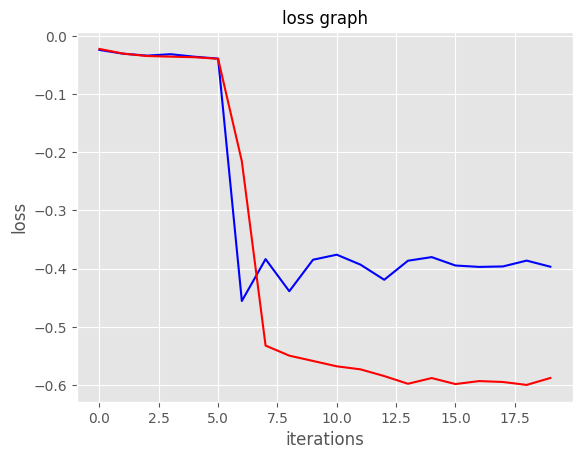

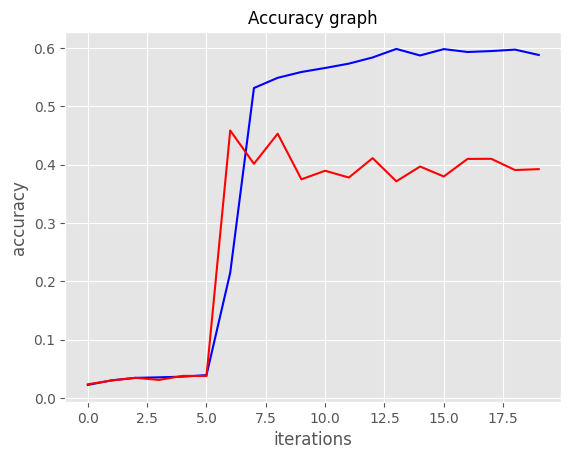

In [21]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

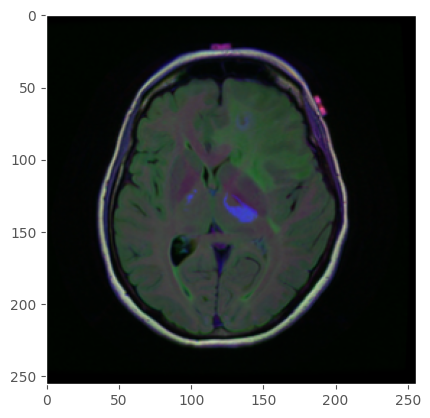

In [34]:
plt.imshow(sample_batch_images[20])
plt.grid(False)

# Visualize the prediction

In [69]:
def visualize_pred_images(image,mask):
    image_expand = np.expand_dims(image,axis=0)
    pred_img = model.predict(image_expand)[0]
    
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.grid(False)
    plt.xlabel("Image")
    
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.grid(False)
    plt.xlabel("Mask")
    
    plt.subplot(1,3,3)
    plt.imshow(pred_img)
    plt.grid(False)
    plt.xlabel("Predicted")
    

1/1 [==============================] - 0s 35ms/step


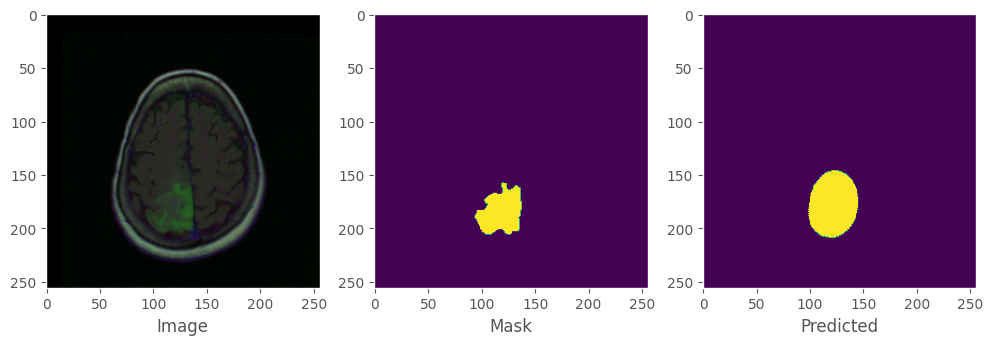

In [73]:
rand_num = random.randint(1,BATCH_SIZE)
visualize_pred_images(sample_batch_images[rand_num],sample_batch_labels[rand_num])

In [98]:
test_gen = data_generator(df_val, BATCH_SIZE, dict(), target_size=(IMG_HEIGHT, IMG_WIDTH)  )

results = model.evaluate(val_gen, steps=len(df_val) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

22/22 [==============================] - 8s 366ms/step - loss: -0.3987 - binary_accuracy: 0.9766 - iou: 0.2572 - dice_coefficients: 0.4040
Test Loss  -0.3987028896808624
Test IoU  0.9766042232513428
Test Dice Coefficient  0.2572252154350281


# Save the pre-trained model

In [81]:
# We already saved the best weights by using ModelCheckpoint

os.mkdir("./models")

# Save the trained model
model.save("./models/MRI_model.h5")

# Save only weights(Recommended)
model.save_weights("./models/MRI_model_weights.h5")

print("Done!!")

Done!!


# Load the pre-trained model

In [86]:
model_trained = UNET(n_classes=1,IMG_WIDTH=IMG_WIDTH,
                     IMG_HEIGHT = IMG_HEIGHT,
                     IMG_CHANNELS=3)

model_trained.load_weights("./models/MRI_model_weights.h5")

1/1 [==============================] - 0s 37ms/step


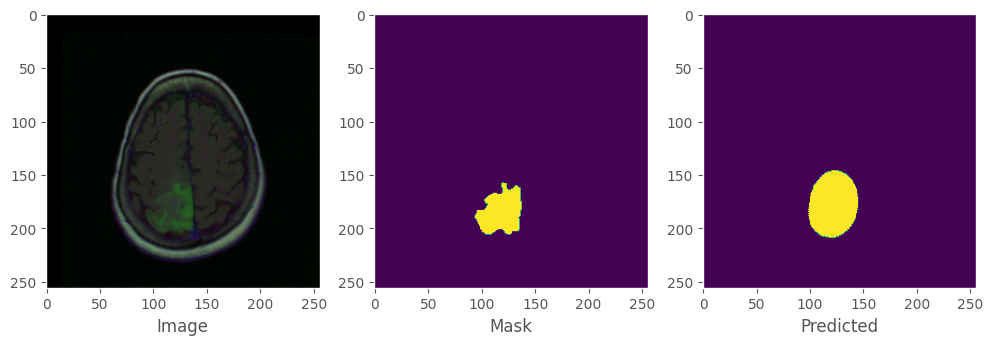

In [151]:
rand_num = random.randint(1,BATCH_SIZE-1)

rand_img = sample_batch_images[rand_num]
rand_mask = sample_batch_labels[rand_num]

rand_img_expand = np.expand_dims(rand_img,axis=0)

visualize_pred_images(rand_img,rand_mask)
